# Sentiment Analysis with Deep Learning
This notebook demonstrates how to build and train a deep learning model for sentiment analysis using TensorFlow. We'll analyze text data to classify sentiments as positive or negative.

## Project Overview
- Dataset: 50,000 labeled text reviews
- Task: Binary sentiment classification
- Approach: Bidirectional LSTM neural network
- Evaluation: Accuracy, Loss metrics

## 1. Data Preparation

### 1.1 Loading Libraries and Data
We'll start by importing necessary libraries and loading our dataset. The data is split into three sets:
- Training set (40,000 samples)
- Testing set (5,000 samples)
- Validation set (5,000 samples)

In [ ]:
import re
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('data/Train.csv')
test = pd.read_csv('data/Test.csv')
val = pd.read_csv('data/Valid.csv')

In [3]:
df = pd.concat([train, test, val]).reset_index(drop=True)

In [4]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
train.shape, test.shape, val.shape

((40000, 2), (5000, 2), (5000, 2))

In [6]:
df.shape

(50000, 2)

In [7]:
df.isna().sum()

text     0
label    0
dtype: int64

In [8]:
df.duplicated().sum()

418

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
len(df['text'].max())

679

In [11]:
df["label"].value_counts()

label
1    24884
0    24698
Name: count, dtype: int64

## 2. Exploratory Data Analysis
Let's analyze our dataset to understand:
- Distribution of positive and negative sentiments
- Text length characteristics
- Common words and patterns
- Data quality (missing values, duplicates)

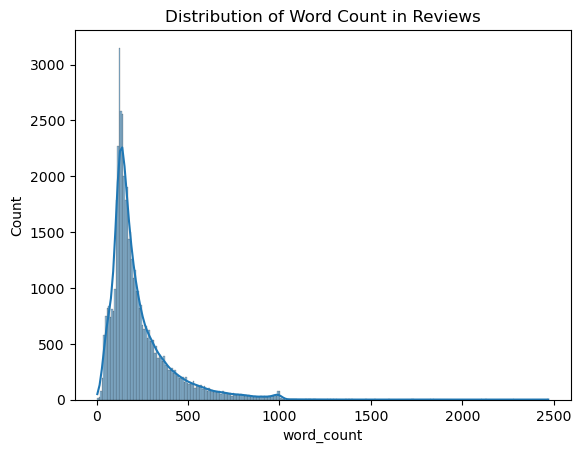

In [12]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], kde=True)
plt.title('Distribution of Word Count in Reviews')
plt.show()

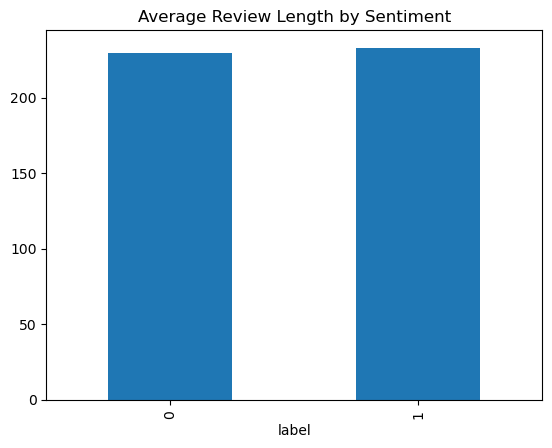

In [13]:
df.groupby('label')['word_count'].mean().plot(kind='bar', title='Average Review Length by Sentiment')
plt.show()

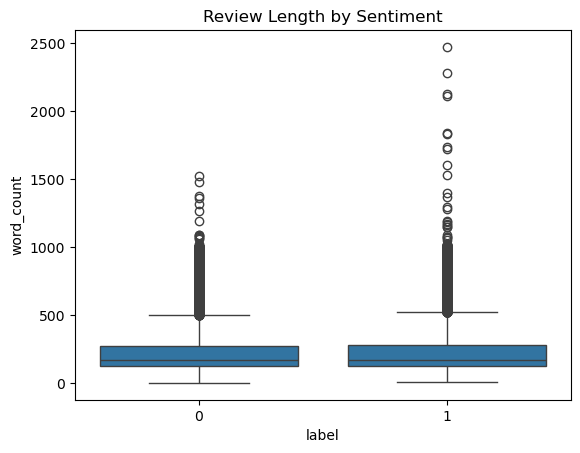

In [14]:
sns.boxplot(x='label', y='word_count', data=df)
plt.title('Review Length by Sentiment')
plt.show()


## 3. Text Preprocessing
Text data requires careful preprocessing before it can be fed into our model. Our preprocessing pipeline includes:
1. Converting text to lowercase
2. Removing HTML tags and special characters
3. Removing stopwords
4. Tokenization
5. Sequence padding

This ensures our data is clean and consistently formatted for model training.

In [15]:
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [16]:
def preprocessing(data, max_words=10000, max_len=500, tokenizer=None):
    data['text'] = data['text'].apply(clean_text)
    
    if tokenizer is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_words,
            oov_token='<OOV>'
        )
        tokenizer.fit_on_texts(data['text'])
    
    sequences = tokenizer.texts_to_sequences(data['text'])
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences,
        maxlen=max_len,
        padding='post',
        truncating='post'
    )
    
    return padded, data['label'], tokenizer

In [17]:
X, y, tokenizer = preprocessing(df)

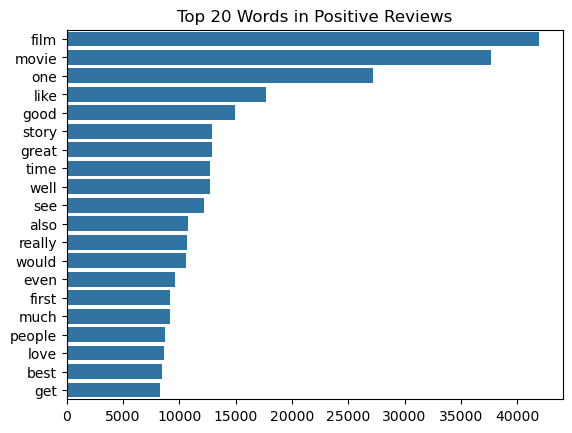

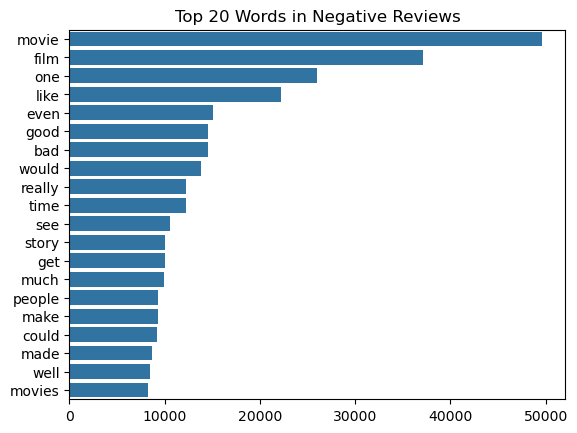

In [18]:
positive_reviews = ' '.join(df[df['label'] == 1]['text']).split()
negative_reviews = ' '.join(df[df['label'] == 0]['text']).split()

positive_words = Counter(positive_reviews).most_common(20)
negative_words = Counter(negative_reviews).most_common(20)

# Plotting
sns.barplot(x=[w[1] for w in positive_words], y=[w[0] for w in positive_words])
plt.title('Top 20 Words in Positive Reviews')
plt.show()

sns.barplot(x=[w[1] for w in negative_words], y=[w[0] for w in negative_words])
plt.title('Top 20 Words in Negative Reviews')
plt.show()


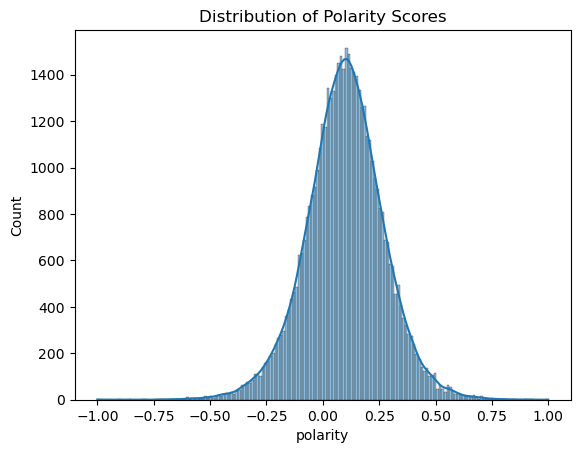

In [19]:
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
sns.histplot(df['polarity'], kde=True)
plt.title('Distribution of Polarity Scores')
plt.show()

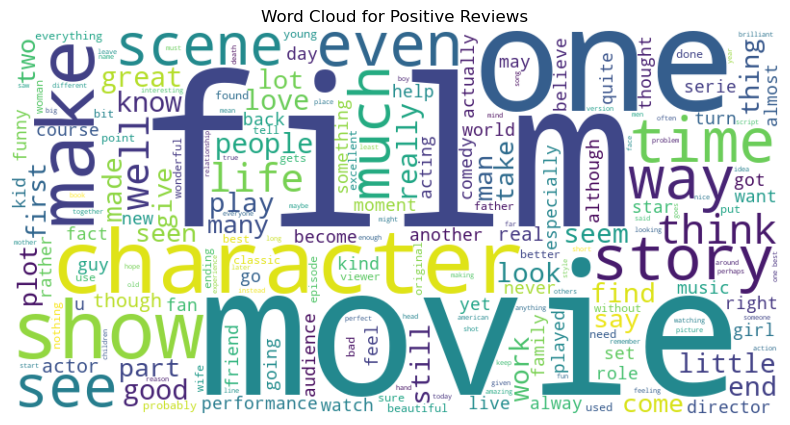

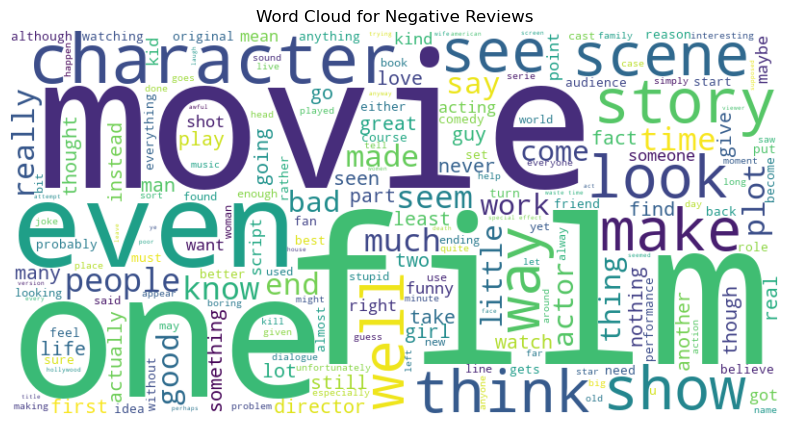

In [20]:
positive_reviews = ' '.join(df[df['label'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

negative_reviews = ' '.join(df[df['label'] == 0]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

In [39]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.05, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## 4. Model Architecture
We'll implement a deep learning model with the following architecture:
- Embedding layer for word representation
- Bidirectional LSTM layers for sequence processing
- Dense layers for classification
- Dropout for regularization

### Model Configuration
- Embedding dimension: 128
- LSTM units: 64, 32
- Dense layer units: 64
- Dropout rate: 0.5
- Activation: ReLU, Sigmoid

In [40]:
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(tokenizer.word_index) + 1, 128, input_length=500),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

In [50]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 500, 128)       │    12,979,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 500, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,370,373 (150.19 MB)

 Trainable params: 13,123,457 (50.06 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,246,916 (100.12 MB)

## 5. Model Training
Training configuration:
- Optimizer: Adam (learning rate = 0.001)
- Loss function: Binary Cross Entropy
- Batch size: 32
- Epochs: 5
- Validation strategy: Hold-out validation set

In [42]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
)

In [43]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/5
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 255s 169ms/step - accuracy: 0.6809 - loss: 1.6767 - val_accuracy: 0.6920 - val_loss: 0.5955
Epoch 2/5
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 204s 137ms/step - accuracy: 0.7323 - loss: 0.5632 - val_accuracy: 0.8336 - val_loss: 0.4333
Epoch 3/5
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 204s 138ms/step - accuracy: 0.8650 - loss: 0.3697 - val_accuracy: 0.8864 - val_loss: 0.3010
Epoch 4/5
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 199s 134ms/step - accuracy: 0.9130 - loss: 0.2628 - val_accuracy: 0.8928 - val_loss: 0.2827
Epoch 5/5
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 202s 136ms/step - accuracy: 0.9300 - loss: 0.2167 - val_accuracy: 0.9040 - val_loss: 0.2915


## 6. Model Evaluation
We'll evaluate our model using:
- Accuracy on test set
- Loss on test set
- Training vs. validation performance curves
- Example predictions

In [44]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.8930 - loss: 0.3465
Test Loss: 0.3232702314853668
Test Accuracy: 0.8944000005722046


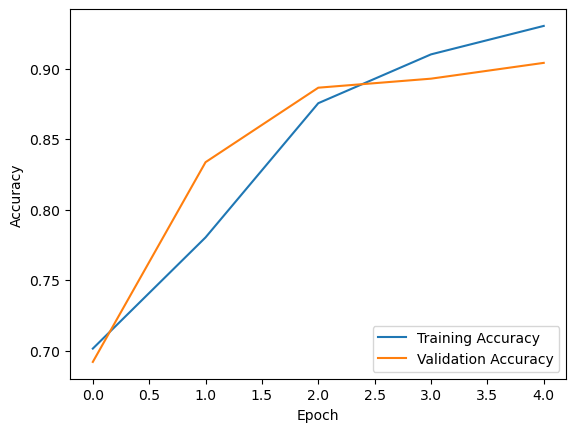

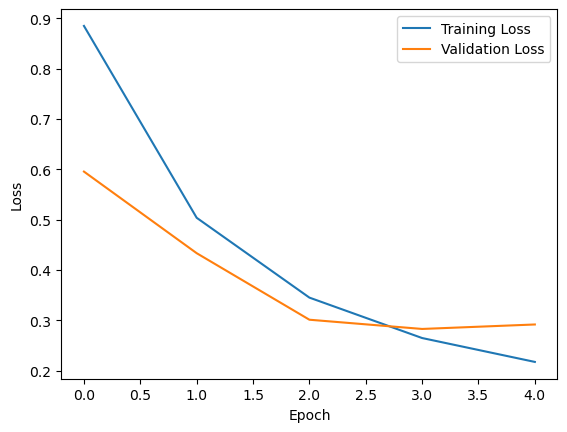

In [45]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


## 7. Making Predictions
Using the trained model to make predictions on new text:
- Text preprocessing
- Model inference
- Interpretation of results

In [46]:
def predict_sentiment(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequence, maxlen=200, padding='post')
    prediction = model.predict(padded)
    return prediction

In [47]:
test_sentence = "I really like this"
(predict_sentiment(test_sentence) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step


array([[1]])

In [49]:
# import pickle
# with open ('sentiment_analysis.pkl', 'wb')as f:
#     pickle.dump(model, f)

## 8. Conclusions
Our sentiment analysis model achieved:
- Test accuracy: 89.44%
- Test loss: 0.323

The model shows strong performance in distinguishing between positive and negative sentiments, with:
- Good generalization (similar training and validation performance)
- Stable training process (smooth learning curves)
- Practical applicability to new text inputs

### Future Improvements
1. Using Transformrs